In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from tqdm import tqdm
import glob
import os
import time
from IPython.display import clear_output

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

In [2]:
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
folder = 'C:/Users/oryan/Documents/mergers-in-cosmos'
student_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/followup-data'
results_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-results'
cosmos_folder = 'E:/cosmos-data'
fits_folder = 'E:/cosmos-fits'
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'

In [3]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [4]:
df = pd.read_csv(f'{data_folder}/secondaries-identified.csv', index_col = 0).reset_index()

In [5]:
df_rename = df.rename(columns = {'index' : 'SourceID', '0' : 'merger'})

In [10]:
df_src = pd.read_csv(f'{data_folder}/cosmos-primary-data.csv', index_col = 0).reset_index().rename(columns = {'index' : 'SourceID'})[['SourceID', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]

In [11]:
df_merge = df_src.merge(df_rename, on = 'SourceID', how = 'left')

In [12]:
df_unknown = df_merge.query('merger == "y"')

In [6]:
files = glob.glob(f'{fits_folder}/*.fits')

In [7]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [8]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

In [15]:
df_unknown.head()

,SourceID,ID,ALPHA_J2000,DELTA_J2000,ez_z_phot,lp_zBEST,merger
2,4000705533312,873195,150.668102,2.242849,0.346519,0.3024,y
14,4000705546183,1224200,150.299990,2.578380,0.595679,0.5805,y
15,4000705546342,1233146,150.283691,2.586769,0.230153,0.2305,y
20,4000705547333,1271349,150.287246,2.625417,0.282621,0.2851,y
30,4000707049110,244303,150.226881,1.648176,0.900248,0.9086,y


In [22]:
sec_dict = {}

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


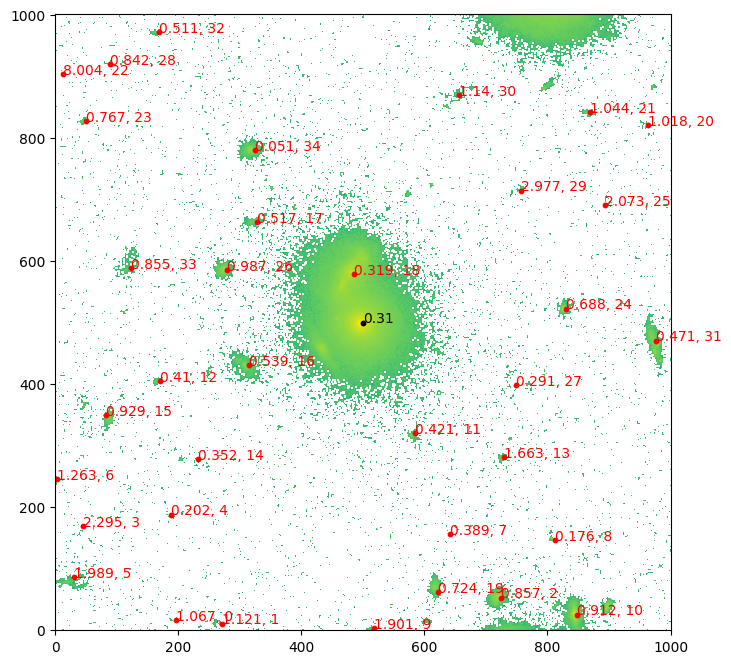

What is the correct secondary? 18


In [34]:
for counter, sourceid in enumerate(list(df_unknown.SourceID)):
    
    if sourceid in list(sec_dict.keys()):
        continue
    
    ra = df_unknown.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df_unknown.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df_unknown.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df_unknown.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df_unknown.query('SourceID == @sourceid')['ID'].iloc[0]
    
    redshift = picking_z(z_ez, z_lp)
    if redshift > 1.5:
        secondaries[sourceid] = 'l'
        continue
    
    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    df_secs = getting_secondary(ra, dec, z_ez, id_str)
    
    file = f'{fits_folder}/{sourceid}.fits'
    
    with fits.open(file) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header
    
    w = WCS(header)
        
    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )
    
    id_list = list(df_coords.ID)
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)
    
    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)
    
    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.imshow(np.log10(im_data), origin = 'lower')
    ax.scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    ax.annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    ax.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for i, txt in enumerate(z_list):
        ax.annotate(f'{np.round(txt, 3)}, {i}', (pixs_arr[i,0], pixs_arr[i,1]), color = 'red')
    plt.show()
    
    if counter % 10 == 0:
        print(np.round(counter / len(df_unknown), 2))
    
    corr_prim_int = int(input('What is the correct secondary?'))
    
    sec_dict[sourceid] = {'prim_id' : id_list[corr_prim_int]}
    
    clear_output(wait = True)

In [41]:
sec_df = pd.DataFrame.from_dict(sec_dict, orient = 'index').reset_index().rename(columns = {'index' : 'SourceID'})

In [42]:
sec_df

,SourceID,prim_id
0,4174947293,534831
1,4175103373,370241
2,4175180745,1050679
3,4175189529,1081854
4,4175190031,1080809
...,...,...
750,6000536013567,1204844
751,6000536013605,1203157
752,6000536014022,1233376
753,6000536014042,1235470


In [43]:
def get_data(id_2020):
    row = data[data['ID'] == id_2020]
    
    if len(row) == 0.0:
        print('ID not found... Something went wrong!')
        sys.exit()
    
    sub_dict = {}
    for i in list(row.names):
        sub_dict[i] = row[i][0]
    
    return sub_dict

In [44]:
secs_dict = {}

In [45]:
done_ids = list(sec_df.keys())
for i in tqdm(list(sec_df.SourceID)):
    id_2020 = sec_df.query('SourceID == @i').prim_id.iloc[0]
    secs_dict[i] = get_data(id_2020)

100%|██████████| 755/755 [05:47<00:00,  2.18it/s]


In [64]:
sec_data = pd.DataFrame.from_dict(secs_dict, orient = 'index').reset_index().rename(columns =  {'index' : 'SourceID'})

In [47]:
sec_data

,ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,KRON_RADIUS,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
4174947293,534831,150.537166,1.925453,12620.632812,15229.711914,0.000026,0.000079,7.763494e-06,9.282132,3.5,...,-11.726256,-11.696641,-11.655727,-11.625052,-11.602901,0.021844,0.021844,0.059668,0.113943,0.178632
4175103373,370241,149.922102,1.772948,27374.685547,11568.441406,0.000015,0.000017,2.544358e-06,4.208591,3.5,...,-10.088194,-9.890476,-9.678571,-9.465669,-9.264844,0.882185,1.004687,1.119567,1.218301,1.277122
4175180745,1050679,149.689747,2.411364,32944.484375,26892.013672,0.000014,0.000026,-1.219963e-05,5.878909,3.5,...,-9.701942,-9.607070,-9.453678,-9.227177,-9.153041,0.457586,0.538307,0.680547,0.916331,1.170079
4175189529,1081854,149.638977,2.441781,34161.722656,27622.449219,0.000026,0.000026,6.326879e-06,6.405669,3.5,...,-9.780084,-9.615581,-9.504002,-9.375662,-9.328797,0.266932,0.311463,0.429879,0.542090,0.654840
4175190031,1080809,149.641244,2.442874,34107.347656,27648.673828,0.000005,0.000005,3.602829e-06,5.010805,3.5,...,-9.870307,-9.800810,-9.684563,-9.566347,-9.478477,0.035082,0.062195,0.122268,0.197986,0.265285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6000536013567,1204844,150.186612,2.557387,21030.166016,30395.082031,0.000016,0.000011,-3.503309e-07,7.589463,3.5,...,-9.985384,-9.963857,-9.908490,-9.864466,-9.821093,0.587652,0.631860,0.689254,0.729754,0.785932
6000536013605,1203157,150.202813,2.558504,20641.730469,30421.910156,0.000051,0.000067,4.840965e-07,4.718683,3.5,...,-9.804204,-9.683063,-9.470870,-9.189605,-8.982660,0.539500,0.595082,0.778112,1.062422,1.232495
6000536014022,1233376,150.198761,2.588354,20738.923828,31138.347656,0.000075,0.000047,4.204851e-06,4.122291,3.5,...,-10.072253,-9.784536,-9.455775,-9.218397,-9.019061,0.886695,1.047800,1.300425,1.590054,1.789402
6000536014042,1235470,150.167244,2.591468,21494.582031,31213.041016,0.000192,0.000159,-7.089978e-05,3.754884,3.5,...,-10.473412,-10.188040,-9.944269,-9.558309,-9.328317,0.672383,0.783993,0.896931,1.052982,1.181907


In [50]:
df_prims_red = df_unknown[['SourceID', 'ID']]
df_prims_red

,SourceID,ID
2,4000705533312,873195
14,4000705546183,1224200
15,4000705546342,1233146
20,4000705547333,1271349
30,4000707049110,244303
...,...,...
3693,4001051778929,1286228
3706,4001111524196,991056
3719,4001185627710,1294479
3766,6000508613553,1140076


In [51]:
prims_dict = {}

In [52]:
for i in tqdm(list(df_prims_red.SourceID)):
    id_2020 = df_prims_red.query('SourceID == @i').ID.iloc[0]
    prims_dict[i] = get_data(id_2020)

100%|██████████| 755/755 [06:10<00:00,  2.04it/s]


In [59]:
prim_data = pd.DataFrame.from_dict(prims_dict, orient = 'index').reset_index().rename(columns =  {'index' : 'SourceID'})

In [65]:
df_comb = pd.concat([prim_data, sec_data])

In [66]:
df_comb

,SourceID,ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705533312,873195,150.668102,2.242849,9482.499023,22848.505859,0.000007,0.000002,1.829277e-06,5.542504,...,-10.363310,-10.187119,-10.050830,-9.911050,-9.815660,1.108623,1.258513,1.362733,1.408040,1.445569
1,4000705546183,1224200,150.299990,2.578380,18311.800781,30899.207031,0.000003,0.000007,-1.436729e-07,4.611166,...,-9.855949,-9.775036,-9.725249,-9.615967,-9.472078,0.981831,1.069094,1.149471,1.264459,1.372974
2,4000705546342,1233146,150.283691,2.586769,18702.609375,31100.500000,0.000026,0.000020,-2.336149e-06,6.911787,...,-9.884939,-9.856074,-9.706545,-9.569586,-9.422319,0.018737,0.018737,0.084962,0.160802,0.262113
3,4000705547333,1271349,150.287246,2.625417,18617.494141,32028.121094,0.000048,0.000050,-1.128192e-05,4.682056,...,-9.191540,-9.177823,-9.158808,-9.125079,-9.103621,0.018737,0.018737,0.018737,0.018737,0.018737
4,4000707049110,244303,150.226881,1.648176,20063.044922,8573.539062,0.000071,0.000091,4.213252e-06,3.920745,...,-9.576005,-9.494349,-9.233552,-8.901307,-8.844178,0.374141,0.493080,0.577505,0.922894,1.169566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,6000536013567,1204844,150.186612,2.557387,21030.166016,30395.082031,0.000016,0.000011,-3.503309e-07,7.589463,...,-9.985384,-9.963857,-9.908490,-9.864466,-9.821093,0.587652,0.631860,0.689254,0.729754,0.785932
751,6000536013605,1203157,150.202813,2.558504,20641.730469,30421.910156,0.000051,0.000067,4.840965e-07,4.718683,...,-9.804204,-9.683063,-9.470870,-9.189605,-8.982660,0.539500,0.595082,0.778112,1.062422,1.232495
752,6000536014022,1233376,150.198761,2.588354,20738.923828,31138.347656,0.000075,0.000047,4.204851e-06,4.122291,...,-10.072253,-9.784536,-9.455775,-9.218397,-9.019061,0.886695,1.047800,1.300425,1.590054,1.789402
753,6000536014042,1235470,150.167244,2.591468,21494.582031,31213.041016,0.000192,0.000159,-7.089978e-05,3.754884,...,-10.473412,-10.188040,-9.944269,-9.558309,-9.328317,0.672383,0.783993,0.896931,1.052982,1.181907


In [67]:
assert len(df_comb) == 2 * len(prim_data)

In [68]:
df_comb.to_csv(f'{combine_fold}/secondary-galaxies-confirmed.csv')